# Experiment Zero

> Acknowledgement: This work builds upon previous OCCaM lab members' work and was done in collaboration with Professor Paul Ruvolo.

## Experiment Overview
The purpose of this experiment is to understand the correlation between the primary evaluation metric (ground truth metric) and noise present in data, as well as assess the quality of Invisible Map's backend optimization and test certain hypotheses as to assumptions made on its performance in a controlled environment. This controlled environment was made by generating data sets for testing, rather than using purely real-world data. This allows us to know the position of odometry nodes and tag positions with 100% confidence, while also sweeping through potential error sources to analyze the correlation between input variance and output error. The hypothesis is that an inputted variance should directly correlate to the corresponding output error (difference in ground truth metric). For example, generating a data set with significant odometry variance should lead to an optimal map with relatively high confidence in tag detections and relatively low confidence in odometry.

Ground truth metric is an error evaluation metric that provides the average Euclidean distance between the predicted positions of the tags and their actual positions (ground truth) for each tag in the dataset. In cases where there are >1 tags present in the map, each tag is turned into an anchor tag (fixed position), and the ground truth metric is found for each tag. The average error for each of these maps is returned as the ground truth metric.

This experiment will be conducted for three different data sets and two main optimizer workflows. The three data sets will vary in size, one small data set, one medium-sized data set, and one large data set to determine any impact the map size has on input-output correlations. The two main optimizer workflows are with Sparse Bundle Adjustment and no Sparse Bundle Adjustment. 

This experiment will be conducted for 

## Data Set Simulation

The data set simulation works by iterating through a given sequence of poses and simulating tag observations at each pose. Gaussian noise can optionally be introduced into both the odometry path and the simulated observation. For a tag to be visible from a given odometry pose, it must meet three criteria:

1. Distance to the tag is under the given threshold.
2. Angle-of-attack to the tag is under the given threshold.
3. Pixel coordinates of the tag fit entirely within the sensor.

Simulated data sets can be either derived from a parametric path or from a real data set. Here, to generate a parametric path that specifies the position of the simulated phone as a function of time, a hard-coded set of tag poses must be provided, and the phone orientation is obtained via a (rotated) Frenet frame computed using a discrete derivative of the path.

## Initialization

Run the following code cell once and only once before executing other tests. This will ensure the correct working directory is set and initialize necessary variables.

In [2]:
small_data_set_name="robolab_straight_on*"
medium_data_set_name=""
large_data_set_name=""
%cd ../..

/home/rdave/invisible-map-generation


In [16]:
from map_processing.data_models import *
from map_processing.graph_generator import GraphGenerator
from map_processing import GT_TAG_DATASETS, PrescalingOptEnum
from map_processing.cache_manager import MapInfo
from map_processing.graph_opt_hl_interface import (
    holistic_optimize,
    WEIGHTS_DICT,
    WeightSpecifier,
)

## No Noise

> Acknowledgement: Part of the write-up for this section comes directly from former student Duncan Mazza's work.

The first iteration of this experiment checks that data simulation is working correctly and ensures that, given no noise inserted into the path and with no conflicting constraints, the ground truth metric is 0. 

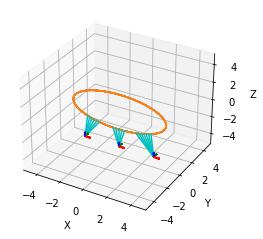

In [8]:
# This data set name corresponds to a hard-coded set of tag poses from the map_processing module.
tag_data_set = "3line"

# These parameters specify an 8 x 4 elliptical path coplanar with the X-Z plane centered at (0, 0, 0);
# because one loop is completed in t=2pi seconds, the t_max parameter of 6pi specifies an elliptical path
# that loops around 3 times.
path_args = {'e_cp': (0.0, 0.0), 'e_xw': 8.0, 'e_zw': 4.0, 'xzp': 0.0}
gen_params = GenerateParams(dataset_name=tag_data_set, parameterized_path_args=path_args, t_max=6 * np.pi,
                            n_poses=100, tag_size=ASSUMED_TAG_SIZE)

gg = GraphGenerator(path_from=GraphGenerator.PARAMETERIZED_PATH_ALIAS_TO_CALLABLE["e"], gen_params=gen_params,
                    tag_poses_for_parameterized=GT_TAG_DATASETS[tag_data_set])

# The data set generation occurs upon construction of a GraphGenerator object; now let's visualize it:
gg.visualize()

The RGB reference frames are the tag observations, and the teal lines denote the translation between the odometry node that observed a tag and the tag.


In [23]:
gen_data_set, gt_data_set = gg.export()
map_info = MapInfo(map_json_name=tag_data_set, map_name=tag_data_set, map_dct=gen_data_set.dict())

fixed_vertices = set()

compute_inf_params = OComputeInfParams(
        lin_vel_var=np.ones(3) * np.sqrt(3),
        tag_sba_var=1.0,
        ang_vel_var=1.0
    )

oconfig = OConfig(is_sba=False, weights=Weights(),
                scale_by_edge_amount=False,
                compute_inf_params=compute_inf_params
            )

opt_result = holistic_optimize(
                map_info=map_info,
                pso=PrescalingOptEnum(1),
                oconfig=oconfig,
                verbose=True,
                visualize=True,
                compare=False,
                upload=False,
                gt_data=GTDataSet.gt_data_set_from_dict_of_arrays(gt_data_set.as_dict_of_se3_arrays) if gt_data_set is not None else None,
            )

ValueError: chi2 is NaN for: <g2o.EdgeSE3 object at 0x7fac47f62070>